# Import required libraries

In [ ]:
!pip install torchinfo

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the device

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cpu


# Load MNIST dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
mnist_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)
data_loader = DataLoader(mnist_dataset, batch_size=128, shuffle=True, drop_last=True)


# Define the Discriminator

In [ ]:
class DISCRIMINATOR(nn.Module):
    def __init__(self):
        super(DISCRIMINATOR, self).__init__()
        # Sequential layers of the discriminator model
        self.discriminator = nn.Sequential(
            nn.Linear(28 * 28, 1024),    # Flatten input images to a 1024-dimension vector
            nn.LeakyReLU(0.2),           # LeakyReLU activation
            nn.Dropout(0.3),             # Dropout to prevent overfitting
            nn.Linear(1024, 512),        # Linear layer to reduce dimensions
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),           # Output layer
            nn.Sigmoid()                 # Sigmoid to produce probability [0, 1]
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # Flatten input images
        return self.discriminator(x)


# Define the GENERATOR architecture

In [ ]:
class GENERATOR(nn.Module):
    def __init__(self):
        super(GENERATOR, self).__init__()
        # Sequential layers of the generator model
        self.generator = nn.Sequential(
            nn.Linear(100, 256),         # Input is noise (100-dimension vector)
            nn.LeakyReLU(0.2),           # LeakyReLU activation
            nn.Linear(256, 512),         # Increase dimension to 512
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),        # Increase dimension to 1024
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28 * 28),    # Output is 28x28 pixels (image size)
            nn.Tanh()                    # Tanh activation to normalize pixel values to [-1, 1]
        )

    def forward(self, x):
        return self.generator(x)  # Pass noise vector through generator layers

# Function to generate random noise

In [ ]:
def random_noise(batch_size):
    return torch.randn(batch_size, 100).to(device)  # Create random noise (batch_size x 100)

# Function to train the discriminator

In [ ]:
def discriminator_training_batch(real_samples, fake_samples, model, criterion, optimizer, real_labels, fake_labels):
    preds_real = model(real_samples)  # Predict on real samples
    error_real = criterion(preds_real, real_labels)  # Compute loss for real samples

    preds_fake = model(fake_samples.detach())  # Predict on fake samples
    error_fake = criterion(preds_fake, fake_labels)  # Compute loss for fake samples

    optimizer.zero_grad()  # Reset gradients
    (error_real + error_fake).backward()  # Backpropagate combined loss
    optimizer.step()  # Update discriminator parameters

    return error_real + error_fake  # Return total loss


# Function to train the generator

In [ ]:
def generator_training_batch(fake_samples, model, criterion, optimizer, real_labels):
    preds = model(fake_samples)  # Predict on fake samples (generated by generator)
    error = criterion(preds, real_labels)  # Compute loss for generator (want it to fool the discriminator)

    optimizer.zero_grad()  # Reset gradients
    error.backward()  # Backpropagate loss
    optimizer.step()  # Update generator parameters

    return error  # Return generator loss

# Set up models, criterion (loss function), and optimizers

In [ ]:
# Instantiate models
discriminator = DISCRIMINATOR().to(device)  # Create discriminator instance
generator = GENERATOR().to(device)  # Create generator instance

# Adam optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)  # Optimizer for discriminator
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)  # Optimizer for generator

# Loss function
criterion = nn.BCELoss()  # Binary cross-entropy loss for real/fake classification

# Pre-initialize real and fake labels once
real_labels = torch.ones(128, 1, device=device)  # Labels for real samples (1s)
fake_labels = torch.zeros(128, 1, device=device)  # Labels for fake samples (0s)

# Train GAN

100%|██████████| 468/468 [01:10<00:00,  6.60it/s]


Epoch [25/100], D Loss: 0.8448, G Loss: 1.7368


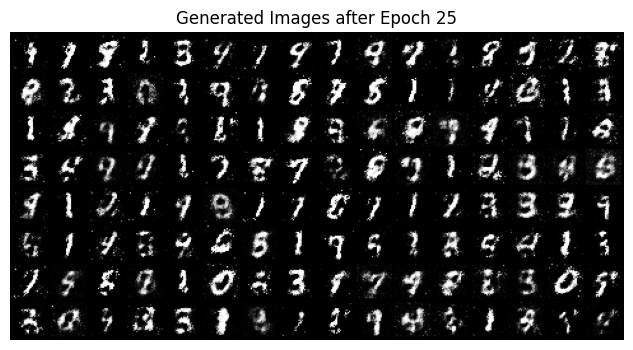

100%|██████████| 468/468 [01:10<00:00,  6.61it/s]


Epoch [50/100], D Loss: 1.0763, G Loss: 1.2535


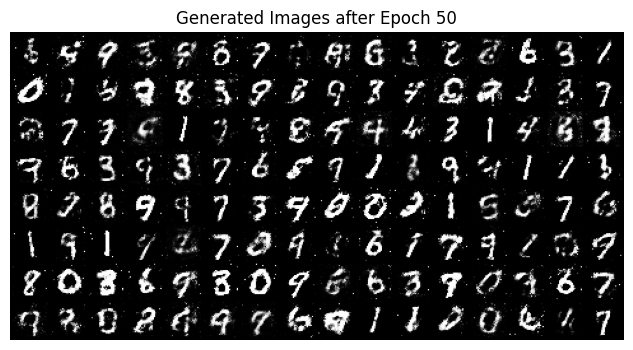

100%|██████████| 468/468 [01:11<00:00,  6.58it/s]


Epoch [75/100], D Loss: 1.1708, G Loss: 1.0679


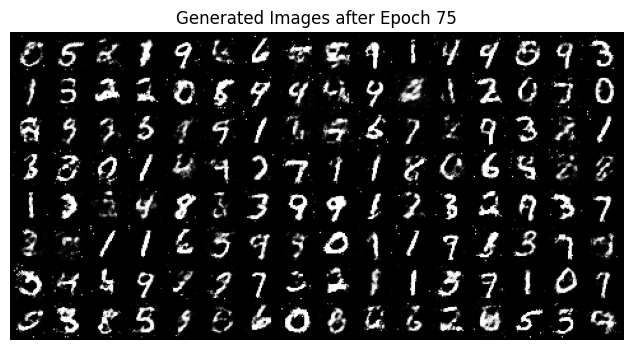

100%|██████████| 468/468 [01:12<00:00,  6.43it/s]


Epoch [100/100], D Loss: 1.2283, G Loss: 0.9723


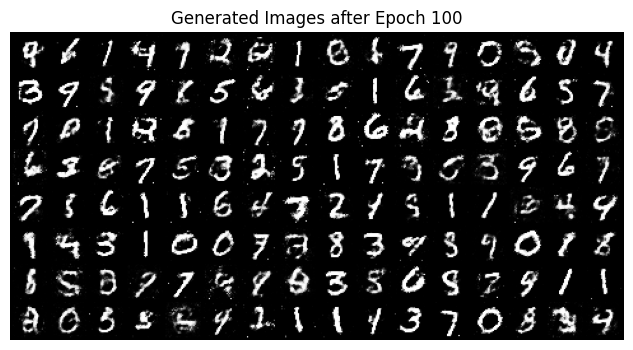

In [ ]:
# Training loop
n_epochs = 100  # Number of training epochs
discriminator_loss, generator_loss = [], []  # Track losses

for epoch in range(n_epochs):
    discriminator_losses, generator_losses = [], []  # Track batch losses

    for real_data, _ in tqdm(data_loader):  # Loop over data batches
        real_data = real_data.to(device)  # Move real data to device
        fake_data = generator(random_noise(batch_size=128)).detach()  # Generate fake data and detach

        # Train discriminator
        discrim_batch_loss = discriminator_training_batch(real_data, fake_data, discriminator, criterion, d_optimizer, real_labels, fake_labels)
        discriminator_losses.append(discrim_batch_loss.item())  # Track discriminator loss

        # Train generator
        fake_data = generator(random_noise(batch_size=128))  # Generate new fake data
        gen_batch_loss = generator_training_batch(fake_data, discriminator, criterion, g_optimizer, real_labels)
        generator_losses.append(gen_batch_loss.item())  # Track generator loss

    # Store average losses per epoch
    discriminator_loss.append(np.mean(discriminator_losses))  # Average discriminator loss
    generator_loss.append(np.mean(generator_losses))  # Average generator loss

    # Log and visualize every 25 epochs
    if (epoch + 1) % 25 == 0:
        print(f'Epoch [{epoch + 1}/{n_epochs}], D Loss: {np.mean(discriminator_losses):.4f}, G Loss: {np.mean(generator_losses):.4f}')

        # Visualize generated images
        with torch.no_grad():  # Disable gradient computation
            noise = random_noise(batch_size=128)
            generated_images = generator(noise).view(-1, 1, 28, 28)  # Generate and reshape images
            grid = make_grid(generated_images.cpu(), nrow=16, normalize=True)  # Create grid of generated images
            plt.figure(figsize=(10, 4))
            plt.imshow(grid.permute(1, 2, 0))  # Plot the grid
            plt.axis('off')
            plt.title(f'Generated Images after Epoch {epoch + 1}')
            plt.show()

# Generate images from noise vectors

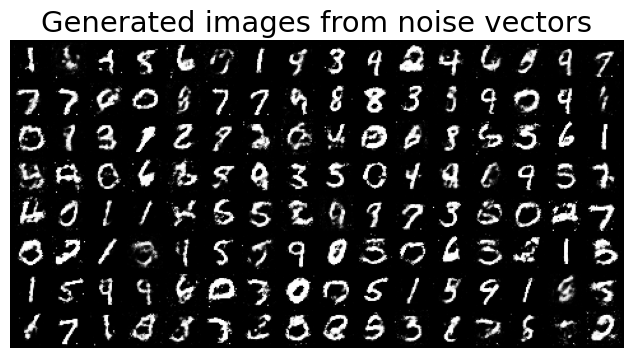

In [ ]:
generator.eval()  # Set generator to evaluation mode
with torch.no_grad():
    noise = random_noise(batch_size=128)  # Generate random noise for final images
    random_samples = generator(noise).view(128, 1, 28, 28)  # Reshape output to image size
    grid = make_grid(random_samples, nrow=16, normalize=True)  # Create grid of final generated images
    plt.figure(figsize=(10, 4))
    plt.imshow(grid.permute(1, 2, 0))  # Plot the grid
    plt.axis(False)
    plt.title('Generated images from noise vectors', fontsize=21)
    plt.show()